In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
class SimpleEmotionCNN(nn.Module):
    def __init__(self):
        super(SimpleEmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64*16*16,512)
        self.fc2 = nn.Linear(512, 7)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0),-1)
        x = torch.relu(self.fc1(x))
        x=self.fc2(x)
        return x
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),  
    transforms.ToTensor()])
train_dataset = datasets.ImageFolder(r"C:\Users\SRINI\Downloads\archive\train", transform=transform)
test_dataset = datasets.ImageFolder(r"C:\Users\SRINI\Downloads\archive\test", transform=transform)
print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 28709
Test dataset size: 7178


In [4]:
num_epochs=10
train_batch_size=32
test_batch_size=32
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)
simple_model=SimpleEmotionCNN()
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(simple_model.parameters(),lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
simple_model.to(device)
for epoch in range(num_epochs):
    simple_model.train()
    running_loss = 0.0  
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = simple_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()   
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")
simple_model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluating"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = simple_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Epoch 1/10: 100%|██████████| 898/898 [05:32<00:00,  2.70it/s]


Epoch 1/10, Loss: 1.6426114355004444


Epoch 2/10: 100%|██████████| 898/898 [05:10<00:00,  2.89it/s]


Epoch 2/10, Loss: 1.4000719934370045


Epoch 3/10: 100%|██████████| 898/898 [04:50<00:00,  3.09it/s]


Epoch 3/10, Loss: 1.2584173313626201


Epoch 4/10: 100%|██████████| 898/898 [04:30<00:00,  3.32it/s]


Epoch 4/10, Loss: 1.1195070772101992


Epoch 5/10: 100%|██████████| 898/898 [04:23<00:00,  3.41it/s]


Epoch 5/10, Loss: 0.9542769447201345


Epoch 6/10: 100%|██████████| 898/898 [04:23<00:00,  3.41it/s]


Epoch 6/10, Loss: 0.7701874732772067


Epoch 7/10: 100%|██████████| 898/898 [04:34<00:00,  3.28it/s]


Epoch 7/10, Loss: 0.5704562840921045


Epoch 8/10: 100%|██████████| 898/898 [04:18<00:00,  3.48it/s]


Epoch 8/10, Loss: 0.39347074884415206


Epoch 9/10: 100%|██████████| 898/898 [04:31<00:00,  3.31it/s]


Epoch 9/10, Loss: 0.26607537613082305


Epoch 10/10: 100%|██████████| 898/898 [04:22<00:00,  3.42it/s]


Epoch 10/10, Loss: 0.1824262618172275


Evaluating: 100%|██████████| 225/225 [00:18<00:00, 12.43it/s]


Accuracy: 0.5229869044302033
Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.39      0.40       958
           1       0.66      0.49      0.56       111
           2       0.42      0.37      0.39      1024
           3       0.70      0.69      0.69      1774
           4       0.44      0.52      0.48      1233
           5       0.42      0.39      0.41      1247
           6       0.65      0.71      0.68       831

    accuracy                           0.52      7178
   macro avg       0.53      0.51      0.52      7178
weighted avg       0.52      0.52      0.52      7178



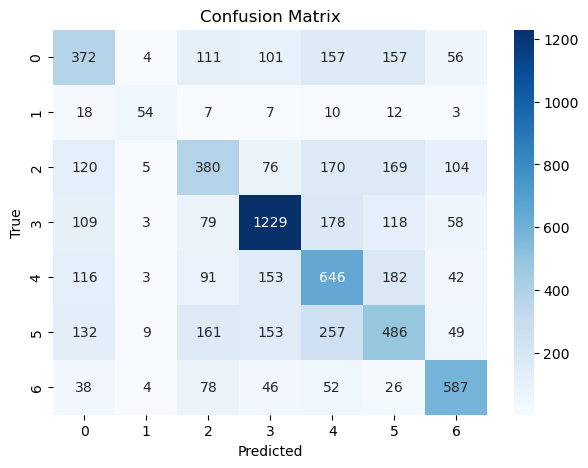

In [5]:
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(all_labels, all_preds))
cm=confusion_matrix(all_labels,all_preds)
plt.figure(figsize=(7,5))
sns.heatmap(cm,annot=True,fmt='g',cmap='Blues',xticklabels=range(7),yticklabels=range(7))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [6]:
sample_image_path=r"C:\Users\SRINI\Downloads\archive\test\happy\PrivateTest_89192537.jpg"
sample_image= Image.open(sample_image_path).convert("L")
sample_image=transform(sample_image).unsqueeze(0)
sample_image=sample_image.to(device)
simple_model.eval()
with torch.no_grad():
    sample_output=simple_model(sample_image)
_,sample_predicted_label=torch.max(sample_output,1)
print(f"Predicted Emotion label  for Sample image: {sample_predicted_label.item()}")

Predicted Emotion label  for Sample image: 3
